In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pinn_lyap import LyapunovNet, prepare_trajectory_data
import pickle

In [3]:
device = 'cpu'
lyapunov_net = LyapunovNet(state_dim=8).to(device)
lyapunov_net.load_state_dict(torch.load('models/lyapunov_zubov.pt', map_location=device))
lyapunov_net.eval()

/tmp/ipykernel_4518/2964918632.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lyapunov_net.load_state_dict(torch.load('models/lyapunov_zubov.pt', map_location=device))


LyapunovNet(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [4]:
with open('data/training_data_y_up.pkl', 'rb') as f:
    dataset = pickle.load(f)
stable_traj_dict = dataset[20]
x_data, f_data = prepare_trajectory_data(stable_traj_dict)

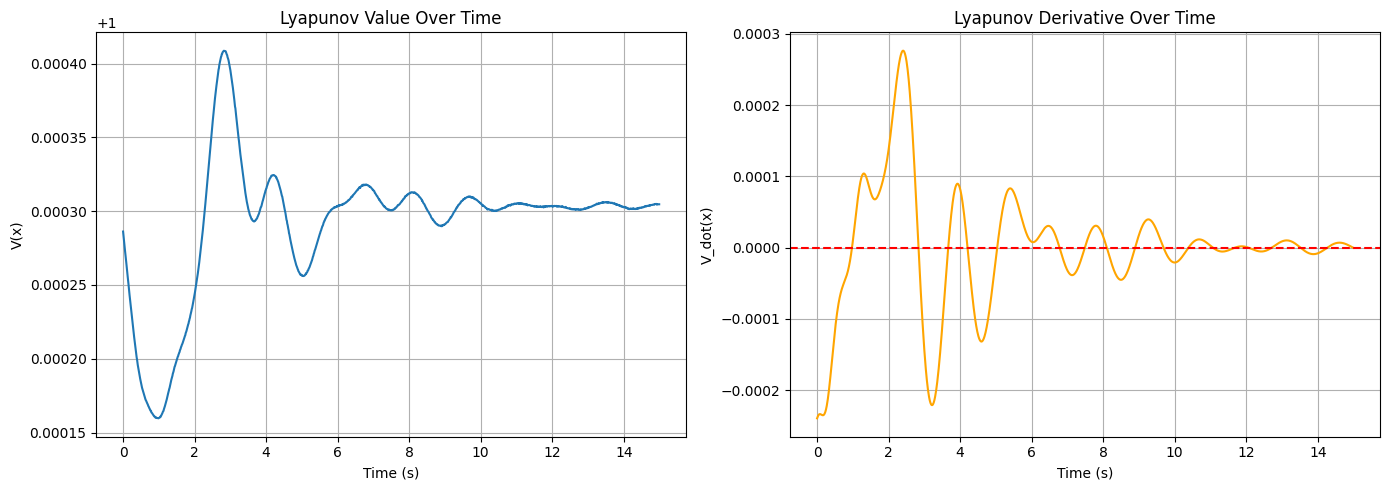

In [5]:
x_tensor = torch.tensor(x_data, device=device)
f_tensor = torch.tensor(f_data, device=device)
time = np.arange(len(x_tensor)) * 0.01

V_over_time = []
V_dot_over_time = []

for i in range(len(x_tensor)):
    state = x_tensor[i:i+1]
    f = f_tensor[i:i+1]
    
    state.requires_grad = True
    V_val = lyapunov_net(state)
    V_grad = torch.autograd.grad(V_val, state, create_graph=True)[0]
    V_dot = (V_grad * f).sum().item()
    
    V_over_time.append(V_val.item())
    V_dot_over_time.append(V_dot)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(time, V_over_time, label='V(x(t))')
ax1.set_title('Lyapunov Value Over Time')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('V(x)')
ax1.grid(True)

ax2.plot(time, V_dot_over_time, label='V_dot(x(t))', color='orange')
ax2.axhline(0, color='red', linestyle='--')
ax2.set_title('Lyapunov Derivative Over Time')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('V_dot(x)')
ax2.grid(True)

plt.tight_layout()
plt.show()